In [ ]:
%pip install -q huggingface_hub datasets
%pip install -q monai matplotlib torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 15.9 MB/s eta 0:00:00


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import monai
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, RandRotate, RandFlip, ToTensor
)
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.data import CacheDataset, Dataset
from monai.losses import DiceLoss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [ ]:
#from datasets import load_dataset
#dataset = load_dataset('albertvillanova/medmnist-v2', 'chestmnist', split=["train", "test"])

!#!/bin/bash
!kaggle datasets download emirhanyldz/chest-xray

Dataset URL: https://www.kaggle.com/datasets/emirhanyldz/chest-xray
License(s): CC0-1.0
100% 2.11G/2.11G [01:53<00:00, 20.7MB/s]
100% 2.11G/2.11G [01:53<00:00, 19.9MB/s]


In [ ]:
!unzip chest-xray.zip -d chest_xrays

Görüntülenen çıkış son 5000 satıra kısaltıldı.
  inflating: chest_xrays/images/00003122_017.png  
  inflating: chest_xrays/images/00003124_000.png  
  inflating: chest_xrays/images/00003129_000.png  
  inflating: chest_xrays/images/00003129_001.png  
  inflating: chest_xrays/images/00003129_004.png  
  inflating: chest_xrays/images/00003129_009.png  
  inflating: chest_xrays/images/00003129_011.png  
  inflating: chest_xrays/images/00003135_000.png  
  inflating: chest_xrays/images/00003140_007.png  
  inflating: chest_xrays/images/00003159_001.png  
  inflating: chest_xrays/images/00003169_001.png  
  inflating: chest_xrays/images/00003177_002.png  
  inflating: chest_xrays/images/00003186_004.png  
  inflating: chest_xrays/images/00003186_005.png  
  inflating: chest_xrays/images/00003190_018.png  
  inflating: chest_xrays/images/00003191_001.png  
  inflating: chest_xrays/images/00003198_002.png  
  inflating: chest_xrays/images/00003198_005.png  
  inflating: chest_xrays/images/000

In [ ]:
import os
import pandas as pd
import shutil
from sklearn.model_selection import train_test_split
from glob import glob

data_dir = "chest_xrays"
csv_path = os.path.join(data_dir, "labels.csv")
imgs_path = os.path.join(data_dir, "images")
df = pd.read_csv(csv_path)

df['label'] = df['Finding Labels'].apply(lambda x: 'NORMAL' if x == 'No Finding' else 'ANOMALY')

In [ ]:
image_paths = [os.path.join(imgs_path, fname) for fname in df["Image Index"]]
labels = df["label"].apply(lambda x: 0 if x == "NORMAL" else 1).values

In [ ]:
train_images, val_images, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import DataLoader
import monai
from monai.transforms import (
    Compose, LoadImage, EnsureChannelFirst, ScaleIntensity, Resize, RandRotate, RandFlip, ToTensor, EnsureType, Lambdad
)
from monai.metrics import ROCAUCMetric
from monai.networks.nets import resnet50
from monai.data import CacheDataset, Dataset, list_data_collate
from monai.losses import DiceLoss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from monai.transforms import RandZoom, RandGaussianNoise, RandGaussianSmooth
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize((224, 224)),
    RandRotate(range_x=15, prob=0.5),
    RandFlip(spatial_axis=0, prob=0.5),
    RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    RandGaussianNoise(prob=0.1),
    ToTensor(),
])

val_transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    ScaleIntensity(),
    Resize((224, 224)),
    ToTensor(),
])


class Chest_Xray_Dataset(torch.utils.data.Dataset):
    def __init__(self, image_files, labels, transforms):
        self.image_files = image_files
        self.labels = labels
        self.transforms = transforms

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, index):
        return self.transforms(self.image_files[index]), self.labels[index]

train_ds = Chest_Xray_Dataset(train_images, train_labels, train_transforms)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

val_ds = Chest_Xray_Dataset(val_images, val_labels, val_transforms)
val_loader = DataLoader(val_ds, batch_size=32)

In [ ]:
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.nn import CrossEntropyLoss
from sklearn.metrics import accuracy_score
from monai.losses import DiceLoss

model = resnet50(
       spatial_dims=2,
       n_input_channels=1,
       num_classes=2,
   ).to(device)
loss_function = DiceLoss(to_onehot_y=True, sigmoid=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

num_epochs = 20
for epoch in range(num_epochs):
    print(f"Epoch {epoch+1}/{num_epochs}")
    model.train()
    epoch_loss = 0
    y_pred_list = []
    y_true_list = []

    for batch_data in train_loader:
        inputs, labels = batch_data[0].to(device), batch_data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()


        _, predicted = torch.max(outputs, 1)
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

    accuracy = accuracy_score(y_true_list, y_pred_list)
    print(f"Ortalama Eğitim Kaybı: {epoch_loss / len(train_loader)}")
    print(f"Accuracy: {accuracy}")

    scheduler.step(epoch_loss)

Epoch 1/20
Ortalama Eğitim Kaybı: 0.3392605777327896
Accuracy: 0.555307760927743
Epoch 2/20
Ortalama Eğitim Kaybı: 0.333424042302666
Accuracy: 0.5854148082069581
Epoch 3/20
Ortalama Eğitim Kaybı: 0.33337575958130206
Accuracy: 0.5825156110615521
Epoch 4/20
Ortalama Eğitim Kaybı: 0.33335901532612794
Accuracy: 0.5807314897413024
Epoch 5/20
Ortalama Eğitim Kaybı: 0.33335079538061263
Accuracy: 0.5805084745762712
Epoch 6/20
Ortalama Eğitim Kaybı: 0.33334586383603143
Accuracy: 0.5814005352363961
Epoch 7/20
Ortalama Eğitim Kaybı: 0.3333434542865618
Accuracy: 0.5867528991971455
Epoch 8/20
Ortalama Eğitim Kaybı: 0.333342194134462
Accuracy: 0.5773862622658341
Epoch 9/20
Ortalama Eğitim Kaybı: 0.3333411647918377
Accuracy: 0.5851917930419268
Epoch 10/20
Ortalama Eğitim Kaybı: 0.3333400788036644
Accuracy: 0.5869759143621767
Epoch 11/20
Ortalama Eğitim Kaybı: 0.333339512770903
Accuracy: 0.5918822479928635
Epoch 12/20
Ortalama Eğitim Kaybı: 0.3333390748247187
Accuracy: 0.5880909901873327
Epoch 13/20
O

In [ ]:
model.eval()
y_true, y_pred = [], []
roc_auc_metric = ROCAUCMetric() 

with torch.no_grad():
    for val_data in val_loader:
        validation_images, validation_labels = val_data[0].to(device), val_data[1].to(device)
        outputs = model(validation_images).argmax(dim=1)

        y_true.extend(validation_labels.cpu().tolist())
        y_pred.extend(outputs.cpu().tolist())

        roc_auc_metric(torch.tensor(outputs.cpu()), torch.tensor(validation_labels.cpu()))

roc_auc = roc_auc_metric.aggregate()
roc_auc_metric.reset()  
print(f"Doğrulama AUC-ROC: {roc_auc.item()}")  

<ipython-input-32-954d72b1e2d5>:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  roc_auc_metric(torch.tensor(outputs.cpu()), torch.tensor(validation_labels.cpu()))


Doğrulama AUC-ROC: 0.6013796147056566


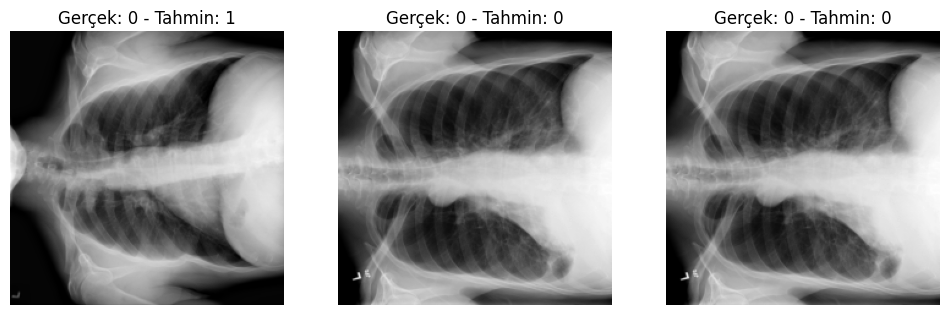

In [ ]:
import random

fig, axs = plt.subplots(1, 3, figsize=(12, 4))
model.eval()
with torch.no_grad():
    for i in range(3):
        idx = random.randint(0, len(val_images) - 1)
        img = val_images[idx] 
        img_label = val_labels[idx]
        img = img.unsqueeze(0).to(device)

        output = model(img).argmax(dim=1).item()

        axs[i].imshow(img.cpu().squeeze(), cmap="gray")
        axs[i].set_title(f"Gerçek: {img_label} - Tahmin: {output}")
        axs[i].axis("off")
plt.show()